## 1.  Делаю импорты и загружаю модели

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim.downloader as api
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
w2v_model = api.load('word2vec-google-news-300')
fasttext_model = api.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded
[==================================================] 100.0% 958.5/958.4MB downloaded


## 2. Работа с данными
#### Загружаю данные

In [ ]:
train_data = pd.read_csv('train_spam.csv')
test_data = pd.read_csv('test_spam.csv')

In [ ]:
train_data.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text_type   16278 non-null  object
 1   text        16278 non-null  object
 2   clean_text  16278 non-null  object
dtypes: object(3)
memory usage: 381.6+ KB


In [ ]:
train_data.isna().sum()

text_type    0
text         0
dtype: int64

Пропусков в данных нет, ничего заполнять не нужно, далее подробнее смотрю на то, как распределены некоторые величины в тестовых данных
#### Анализ распределения данных

In [ ]:
stat_data = train_data.copy()

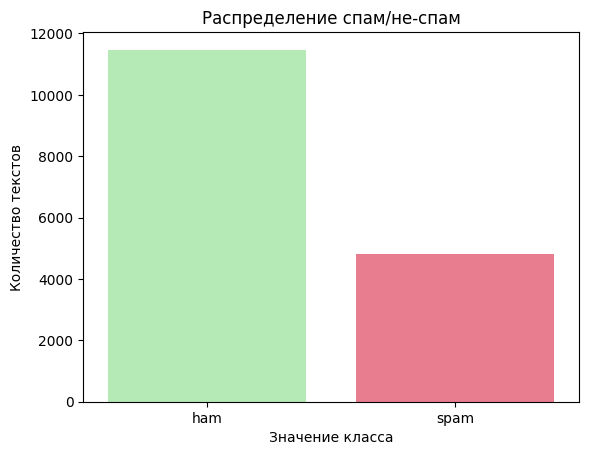

In [ ]:
fg = sns.countplot(x=stat_data['text_type'], hue=stat_data['text_type'], palette=['#ACF3AE', '#FA6B84'])
fg.set_title('Распределение спам/не-спам')
fg.set_xlabel('Значение класса')
fg.set_ylabel('Количество текстов')
plt.show()

Есть дисбаланс классов: не-спам текстов более чем в 2 раза больше

In [ ]:
stat_data['characters'] = stat_data['text'].apply(len)
stat_data['words'] = stat_data.apply(lambda row: word_tokenize(row['text']), axis=1).apply(len)
stat_data['sentence'] = stat_data.apply(lambda row: nltk.sent_tokenize(row['text']), axis=1).apply(len)

stat_data[['characters', 'words', 'sentence']].describe().T

,count,mean,std,min,25%,50%,75%,max
characters,16278.0,310.383524,287.818154,1.0,60.0,157.0,639.0,800.0
words,16278.0,57.124647,52.122445,1.0,12.0,31.0,114.0,207.0
sentence,16278.0,1.062170,0.375992,1.0,1.0,1.0,1.0,12.0


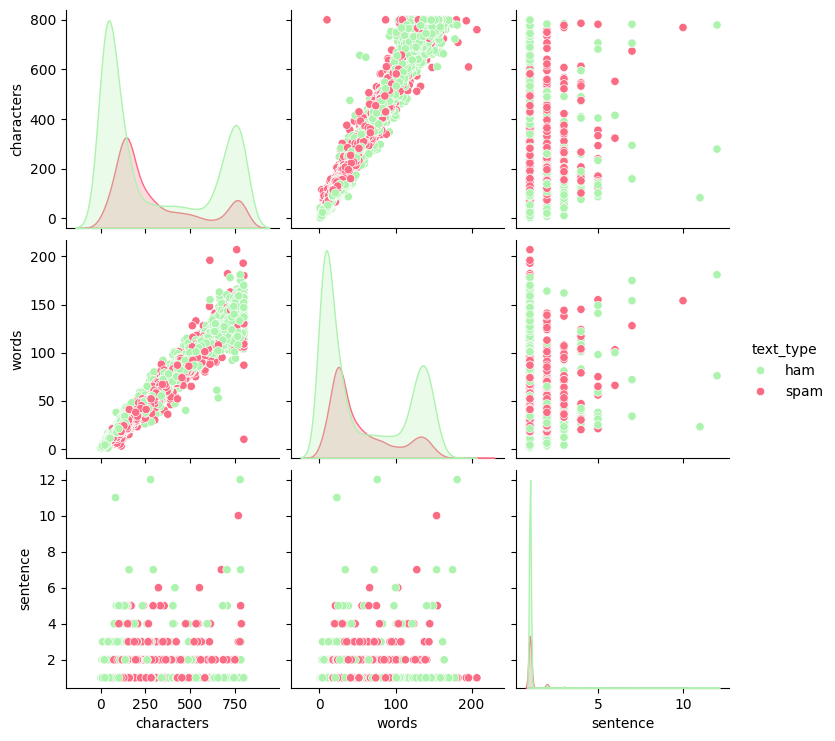

In [ ]:
fg = sns.pairplot(stat_data, hue='text_type', palette=['#ACF3AE', '#FA6B84'])
plt.show()

Во всех данных примерно одинаковое распределение различных величин, нет выбросов, особой разницы ни в количестве предложений, ни в длине или количестве слов нет, поэтому для задачи классфикации будет основана на наполнении текстов
#### Препроцессинг текстов и разделение выборок
Обрабатываю тексты для дальнейшего обучения: токенизирую, лемматизирую, удаляю стоп-слова

In [ ]:
def clean_text(text):
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    text = word_tokenize(text.lower())
    text = [word for word in text if word not in stop_words]
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

In [ ]:
%%time
train_data['clean_text'] = train_data['text'].apply(clean_text)
test_data['clean_text'] = test_data['text'].apply(clean_text)

CPU times: user 12.2 s, sys: 96.3 ms, total: 12.3 s
Wall time: 12.4 s


Делю train датасет на train и val и сохраняю три датасета в удобном формате

In [ ]:
train_data['spam'] = train_data['text_type'].apply(lambda x:1 if x=='spam' else 0)
train_data.head(5)

,text_type,text,clean_text,spam
0,ham,make sure alex knows his birthday is over in f...,"[make, sure, alex, know, birthday, fifteen, mi...",0
1,ham,a resume for john lavorato thanks vince i will...,"[resume, john, lavorato, thanks, vince, get, m...",0
2,spam,plzz visit my website moviesgodml to get all m...,"[plzz, visit, website, moviesgodml, get, movie...",1
3,spam,urgent your mobile number has been awarded wit...,"[urgent, mobile, number, awarded, 2000, prize,...",1
4,ham,overview of hr associates analyst project per ...,"[overview, hr, associate, analyst, project, pe...",0


In [ ]:
train_ids, val_ids = train_test_split(train_data.index, test_size=0.25, stratify=train_data.text_type)

In [ ]:
train_dataset, val_dataset = train_data[['clean_text', 'spam']].loc[train_ids], train_data[['clean_text', 'spam']].loc[val_ids]

In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12208 entries, 14683 to 4101
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   clean_text  12208 non-null  object
 1   spam        12208 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 286.1+ KB


In [ ]:
val_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4070 entries, 3260 to 6487
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   clean_text  4070 non-null   object
 1   spam        4070 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 95.4+ KB


In [ ]:
test_data = test_data[['clean_text']]

In [ ]:
train_dataset.to_csv('clean_train.csv', header=True, index=True)
val_dataset.to_csv('clean_val.csv', header=True, index=True)
test_data.to_csv('clean_test.csv', header=True, index=True)

In [3]:
df_train = pd.read_csv('clean_train.csv', header=0, index_col=0).fillna('')
df_val = pd.read_csv('clean_val.csv', header=0, index_col=0).fillna('')
df_test = pd.read_csv('clean_test.csv', header=0, index_col=0).fillna('')

## 3. Векторизация текстов


In [110]:
embeds = {}

#### 3.1. Word distribution

In [111]:
count_vectorizer = CountVectorizer()
X_train_count = count_vectorizer.fit_transform(df_train.clean_text)
X_val_count = count_vectorizer.transform(df_val.clean_text)

In [112]:
X_train_count.shape, X_val_count.shape

((12208, 37189), (4070, 37189))

In [113]:
embeds['Count'] = {'train': X_train_count, 'val': X_val_count}

#### 3.2. TF-IDF

In [114]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train.clean_text)
X_val_tfidf = tfidf_vectorizer.transform(df_val.clean_text)

In [115]:
X_train_tfidf.shape, X_val_tfidf.shape

((12208, 37189), (4070, 37189))

In [116]:
embeds['TFIDF'] = {'train': X_train_tfidf, 'val': X_val_tfidf}

#### 3.3. Word2Vec

In [51]:
class Word2VecVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self):
        self._model = w2v_model

    def fit(self, X, y=None):
        self.is_fitted_ = True
        return self

    def transform(self, X):
        vectors = []
        for sentence in X:
            if sentence:
                vector = self._model.get_mean_vector(
                    sentence,
                    pre_normalize=False,
                    ignore_missing=True
                    )
            else:
                vector = np.zeros(self._model.vector_size)
            vectors.append(vector)
        return np.array(vectors)

In [117]:
w2v_vectorizer = Word2VecVectorizer()
X_train_w2v = w2v_vectorizer.fit_transform(df_train.clean_text)
X_val_w2v = w2v_vectorizer.transform(df_val.clean_text)

In [118]:
X_train_w2v.shape, X_val_w2v.shape

((12208, 300), (4070, 300))

In [119]:
embeds['Word2Vec'] = {'train': X_train_w2v, 'val': X_val_w2v}

#### 3.4. FastText

In [55]:
class FastTextVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self):
        self._model = fasttext_model

    def fit(self, X, y=None):
        self.is_fitted_ = True
        return self

    def transform(self, X):
        vectors = []
        for sentence in X:
            if sentence:
                vector = self._model.get_mean_vector(
                    sentence,
                    pre_normalize=False,
                    ignore_missing=True
                    )
            else:
                vector = np.zeros(self._model.vector_size)
            vectors.append(vector)
        return np.array(vectors)

In [120]:
ft_vectorizer = FastTextVectorizer()
X_train_ft = ft_vectorizer.fit_transform(df_train.clean_text)
X_val_ft = ft_vectorizer.transform(df_val.clean_text)

In [121]:
X_train_ft.shape, X_val_ft.shape

((12208, 300), (4070, 300))

In [122]:
embeds['FastText'] = {'train': X_train_ft, 'val': X_val_ft}

## 4. Классификаторы

Не все способо векторизации подходят для некоторых классификаторов, поэтому будем отдельно рассматривать каждый метод. В качестве применяемых алгоритмов классификации берем MultinomialNB, RandomForestClassifier, LogisticRegression и SVC, как одни из самых популярных алгоритмов.

In [123]:
classifiers  = {
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(),
    'LogReg': LogisticRegression(),
    #'svc': SVC()
}

In [124]:
train_target = df_train.spam.to_numpy()
val_target = df_val.spam.to_numpy()

In [125]:
roc_auc = []

In [126]:
for name, clf in classifiers.items():
    if name == 'Naive Bayes':
        for key, embed in embeds.items():
          if key == 'Word2Vec' or key == 'FastText':
              pass
          else:
              clf.fit(embed['train'], train_target)
              val_pred = clf.predict_proba(embed['val'])
              val_roc_auc = roc_auc_score(val_target, val_pred[:, 1])

              roc_auc.append({
            'classifier': name,
            'vectorizer': key,
            'roc_auc': val_roc_auc})

    else:
        for key, embed in embeds.items():
            clf.fit(embed['train'], train_target)

            val_pred = clf.predict_proba(embed['val'])
            val_roc_auc = roc_auc_score(val_target, val_pred[:, 1])

            roc_auc.append({
          'classifier': name,
          'vectorizer': key,
          'roc_auc': val_roc_auc})

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


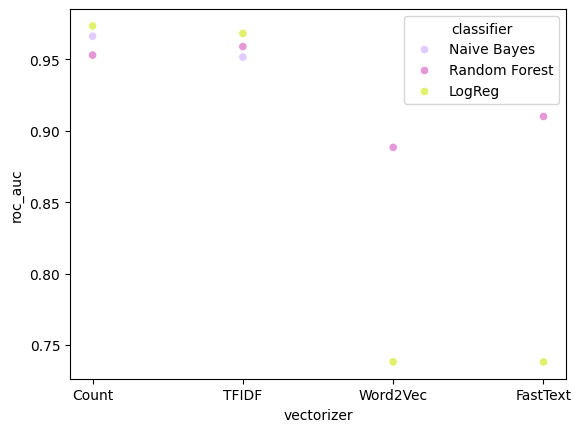

In [127]:
fg = sns.scatterplot(data=pd.DataFrame(roc_auc), x='vectorizer', y='roc_auc', hue='classifier', palette=['#E2CCFF','#E598D8', '#E1F16B'])
fg.set_xlabel('Значение класса')
fg.set_ylabel('Количество текстов')
fg.set_huelabel('Количество текстов')
plt.show()